# Visual relaxation of a graph

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [279]:
class Graph:
    def __init__(self, gdict=None, xyarray=None):
        if gdict is not None:
            self.gdict = gdict
        else:
            self.gdict = {}
        self.xy = {}
        if xyarray is not None:
            for i,_ in self.gdict.items():
                self.xy[i] = xyarray[i,]
                
    def dist(self,i,j):
        return np.sqrt(np.square(self.xy[i][0]-self.xy[j][0]) + np.square(self.xy[i][1]-self.xy[j][1]))

    def plot(self):
        for i,val in self.gdict.items():
            for j in val:
                plt.plot([self.xy[i][0], self.xy[j][0]], [self.xy[i][1], self.xy[j][1]], 'k.-')
        
    def splice(self, i,j, newxy=None):
        """Add a point between two existing points."""
        self.gdict[i].remove(j)
        self.gdict[j].remove(i)
        k = max(self.gdict.keys())+1
        self.gdict[k] = [i,j]
        self.gdict[i].append(k)
        self.gdict[j].append(k)
        if newxy is None:
            newxy = (self.xy[i]+self.xy[j])/2
        self.xy[k] = newxy
        return k

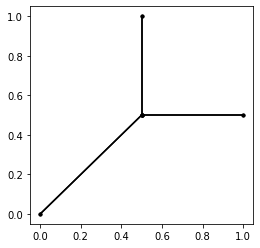

In [744]:
g = Graph({0:[1], 1:[0,2,3], 2:[1], 3:[1]}, 
          np.array([[0,0], [0.5,0.5], [1,0.5], [0.5,1]]))

plt.figure(figsize=(4,4))
g.plot()

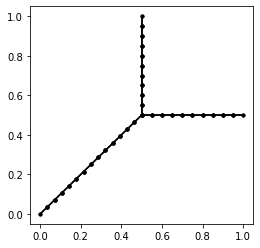

In [745]:
def interpolate(g, min_d=0.1):
    """Intepolate the graph."""
    for i,others in list(g.gdict.items()):
        for j in others:
            d = g.dist(i,j)
            nsteps = int(d/min_d)
            if nsteps>1:
                step = (g.xy[j]-g.xy[i])/nsteps
                edge1 = i
                edge2 = j
                for istep in range(1,nsteps):
                    point = g.xy[i] + step*istep
                    k = g.splice(edge1, edge2, point)
                    edge1 = k
    return g
    
plt.figure(figsize=(4,4))
g = interpolate(g, 0.05)
g.plot()

OK, the formulas below are totally wrong, as cross-product 0 at right angle, and we need something that would zero at opposite vectors. It's true that it should max at co-aligned vectors, but it should 0 (or at least min) for opposite vectors.

Can it be (dot()+1)/2 ?

[0.00056157 0.00053455]
[-0.13494852 -0.04569206]
[ 0.00133401 -0.000314  ]


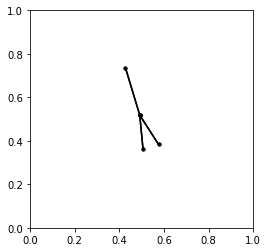

In [982]:
def relax(g, d_min=0.1, nsteps=10):
    """Turn a graph into ribbons."""
    ALPHA = 0.05
    for istep in range(nsteps):
        distance = {}
        for i,js in g.gdict.items():            
            for j in js:                
                if i<j: # Spring-like action
                    distance[(i,j)] = g.dist(i, j)
                    distance[(j,i)] = distance[(i,j)]
                    force = (distance[(i,j)] - d_min)*(g.xy[j] - g.xy[i])
                    g.xy[i] += force*ALPHA
                    g.xy[j] += -force*ALPHA
        for i,js in g.gdict.items():            
            for j in js:
                for k in js: # Repulsion
                    if k<j:
                        if (i,j) not in distance: 
                            distance[(i,j)] = g.dist(i, j)
                            distance[(j,i)] = distance[(i,j)]
                        if (i,k) not in distance: 
                            distance[(i,k)] = g.dist(i, k)
                            distance[(k,i)] = distance[(i,k)]
                        mean = (g.xy[j]+g.xy[k])/2 - g.xy[i]
                        force = ((np.dot(g.xy[j]-g.xy[i], g.xy[k]-g.xy[i])/distance[(i,j)]/distance[(i,k)]+1)/2*
                                 np.array([mean[1],-mean[0]]))
                        print(force)
                        g.xy[j] += force*ALPHA
                        g.xy[k] += -force*ALPHA
    
# Testing
# g = Graph({0:[1], 1:[0,2,3], 2:[1], 3:[1]}, np.array([[0,0], [0.5,0.5], [1,0.5], [0.5,1]]))
#g = interpolate(g, 0.05)
relax(g, nsteps=1)
plt.figure(figsize=(4,4))
g.plot()
plt.xlim(0,1);
plt.ylim(0,1);